#Задание для курсового проекта
Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Построение модели классификации

 * Обзор обучающего датасета
 * Обработка выбросов
 * Обработка пропусков
 * Анализ данных
 * Отбор признаков
 * Подбор моделей, получение бейзлана
 * Проверка качества, борьба с переобучением
 * Интерпретация результатов

Прогнозирование на тестовом датасете

 * Выполнить для тестового датасета те же этапы обработки и постронияния признаков
 * Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
 * Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
 * Соблюдать исходный порядок примеров из тестового датасета

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


Описание датасета

 * Id - идентификационный номер квартиры
 * DistrictId - идентификационный номер района
 * Rooms - количество комнат
 * Square - площадь
 * LifeSquare - жилая площадь
 * KitchenSquare - площадь кухни
 * Floor - этаж
 * HouseFloor - количество этажей в доме
 * HouseYear - год постройки дома
 * Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
 * Social_1, Social_2, Social_3 - социальные показатели местности
 * Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
 * Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
 * Price - цена квартиры

Загрузим данные и посмотрим первые 7 строк

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head(7)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272


Узнаем типы данных, а также проверим наличие пропусков.

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Изменим тип данных 'Id' и 'DistrictId' на строковый, т.к. эти данные являются категориальными и не будут учавствовать в обучении модели

In [4]:
train_df[['Id', 'DistrictId']] = train_df[['Id', 'DistrictId']].astype('str')

Посмотрим на целевую переменную

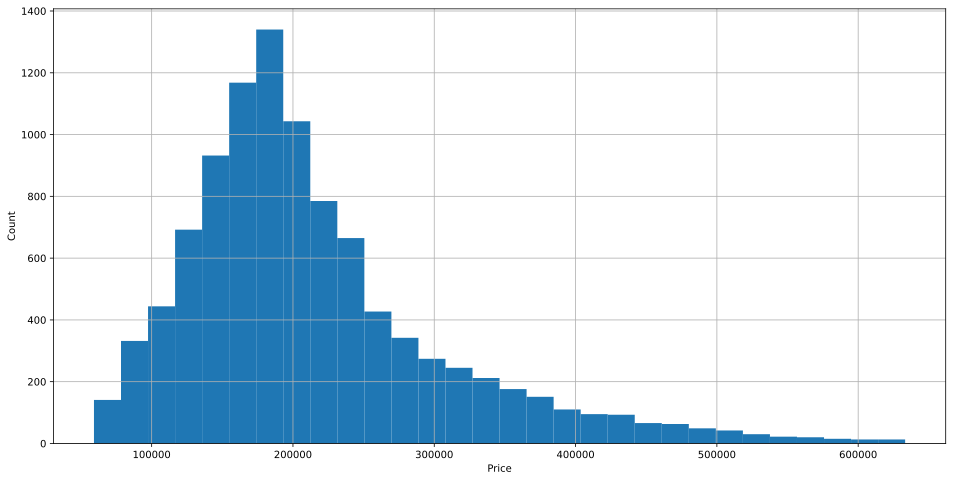

In [5]:
plt.figure(figsize=(16,8))
train_df['Price'].hist(bins=30)
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

Поиск признаков с выбросами

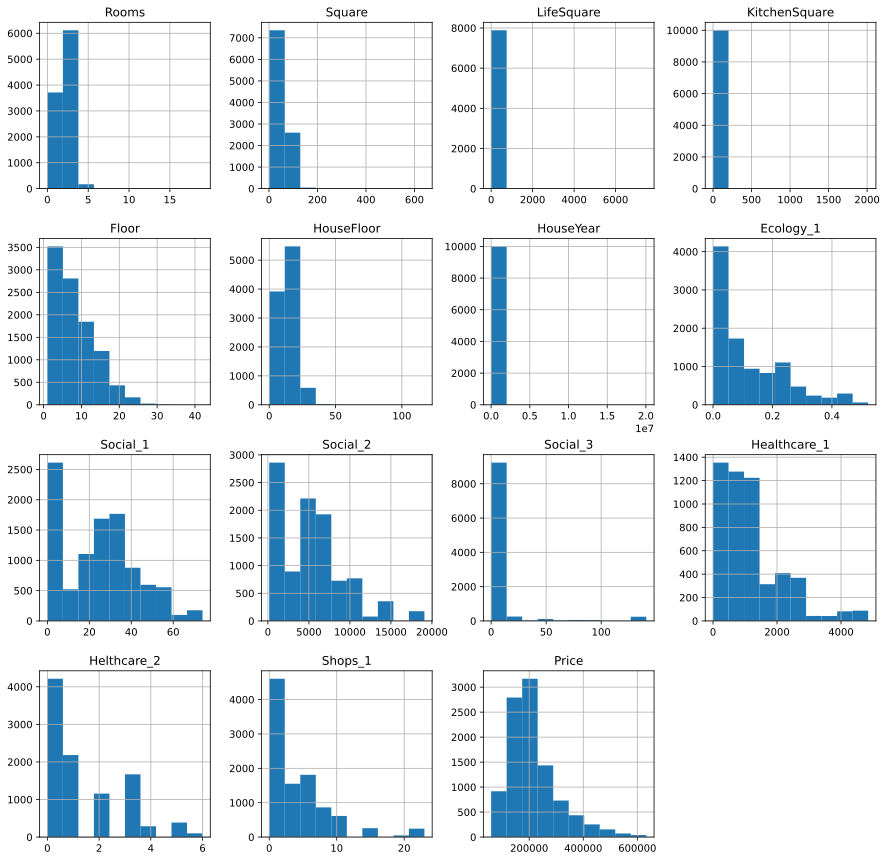

In [6]:
num_feat = list(train_df.select_dtypes(exclude='object').columns)
train_df[num_feat].hist(
    figsize=(15,15)
)
plt.show()

Получим первичное представление о статистических характеристиках нашего датасета

In [7]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Замечаем аномальные значения некоторых переменных (минимальные значения количества комнат, общей площади, жилой площади, площади кухни, а также все характеристики года постройки).  Изучаем и обрабатываем выбросы.

In [8]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Количество комнат больше 6-ти, а также равное нулю, заменим на медианное.

In [9]:
train_df['Square'].value_counts(bins=50)

(39.533, 52.331]      3294
(52.331, 65.13]       2379
(26.734, 39.533]      1632
(65.13, 77.928]       1274
(77.928, 90.727]       958
(90.727, 103.525]      215
(103.525, 116.324]      91
(116.324, 129.123]      58
(13.935, 26.734]        32
(129.123, 141.921]      25
(0.496, 13.935]         13
(167.518, 180.317]       8
(154.72, 167.518]        6
(141.921, 154.72]        4
(180.317, 193.115]       4
(193.115, 205.914]       2
(269.907, 282.705]       1
(602.669, 615.468]       1
(397.892, 410.691]       1
(628.267, 641.065]       1
(205.914, 218.712]       1
(257.108, 269.907]       0
(244.31, 257.108]        0
(615.468, 628.267]       0
(589.871, 602.669]       0
(577.072, 589.871]       0
(564.274, 577.072]       0
(551.475, 564.274]       0
(538.677, 551.475]       0
(525.878, 538.677]       0
(513.08, 525.878]        0
(500.281, 513.08]        0
(487.482, 500.281]       0
(474.684, 487.482]       0
(461.885, 474.684]       0
(449.087, 461.885]       0
(436.288, 449.087]       0
(

В данной выборке видим, что в диапазоне от 180,317 кв.м. и выше находится незначительное количество квартир. А диапазон 0,496-13,935 просмотрим подробнее, т.к. в нем находится 13 квартир.

In [10]:
train_df['Square'][train_df['Square']<14]

161      2.954309
328      4.390331
1401     5.129222
4496     1.988943
4800     4.502784
5009     4.633498
7033     5.497061
7470     1.136859
8572     2.596351
8805     4.380726
9067     4.823679
9286    13.784865
9869     2.377248
Name: Square, dtype: float64

Общую площадь квартиры более 181 кв.м. и менее 13 кв.м. заменим на медианную.

Аналогичные действия проведём с жилой площадью и площадью кухни. А также в жилой площади заменим пропуски медианой

In [11]:
train_df['LifeSquare'].value_counts(bins=50)

(-7.111000000000001, 149.975]    7872
(149.975, 299.579]                 11
(598.788, 748.393]                  1
(7330.988, 7480.592]                1
(449.184, 598.788]                  1
(299.579, 449.184]                  1
(5685.339, 5834.943]                0
(4488.504, 4638.108]                0
(4638.108, 4787.712]                0
(4787.712, 4937.317]                0
(4937.317, 5086.921]                0
(5086.921, 5236.526]                0
(5236.526, 5386.13]                 0
(5386.13, 5535.735]                 0
(5535.735, 5685.339]                0
(5834.943, 5984.548]                0
(4189.295, 4338.899]                0
(5984.548, 6134.152]                0
(6134.152, 6283.757]                0
(6283.757, 6433.361]                0
(6433.361, 6582.966]                0
(6582.966, 6732.57]                 0
(6732.57, 6882.174]                 0
(6882.174, 7031.779]                0
(7031.779, 7181.383]                0
(7181.383, 7330.988]                0
(4338.899, 4

In [12]:
train_df['KitchenSquare'].value_counts(bins=50)

(-2.0149999999999997, 40.28]    9973
(40.28, 80.56]                    20
(80.56, 120.84]                    4
(1933.44, 1973.72]                 1
(1973.72, 2014.0]                  1
(120.84, 161.12]                   1
(201.4, 241.68]                    0
(1530.64, 1570.92]                 0
(1208.4, 1248.68]                  0
(1248.68, 1288.96]                 0
(1288.96, 1329.24]                 0
(1329.24, 1369.52]                 0
(1369.52, 1409.8]                  0
(1409.8, 1450.08]                  0
(1450.08, 1490.36]                 0
(1490.36, 1530.64]                 0
(1570.92, 1611.2]                  0
(1127.84, 1168.12]                 0
(1611.2, 1651.48]                  0
(1651.48, 1691.76]                 0
(1691.76, 1732.04]                 0
(1732.04, 1772.32]                 0
(1772.32, 1812.6]                  0
(1812.6, 1852.88]                  0
(1852.88, 1893.16]                 0
(1893.16, 1933.44]                 0
(1168.12, 1208.4]                  0
(

Проверим данные по году постройки

In [13]:
train_df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1910           1
1916           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

Ограничим год постройки 2022-ым годом с заменой на медиану.

Проверим, сколько квартир по этажности превышает этажность здания

In [14]:
train_df[['Floor', 'HouseFloor']][train_df['Floor'] > train_df['HouseFloor']].count() 

Floor         1825
HouseFloor    1825
dtype: int64

Подкорректируем этажность здания до указанного этажа квартиры

Пропуски признака 'Healthcare_1' также заменяем медианой.

Посмотрим на категориальные переменные.

In [15]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [16]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [17]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [18]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Т.к. переменные 'Ecology_2', 'Ecology_3' и 'Shops_2' имеют только 2 значения, можем их также использовать при обучении модели, заменив значения "А" и "В" на 0 и 1. 

Все вышеуказанные действия оформляем в виде функций.

In [19]:
class Data_prepr:
  def __init__(self):
      self.medians = None
  def fit(self, train_df):
    self.medians = train_df.median()
  def transform_em(self, data):
    data.loc[(data['Rooms'] == 0) | (data['Rooms'] > 6) , 'Rooms'] = self.medians['Rooms']
    data.loc[(data['Square'] > 181) | (data['Square'] < 13), 'Square'] = self.medians['Square']
    data.loc[(data['LifeSquare'] <13) | (data['LifeSquare'] > 150), 'LifeSquare'] = self.medians['LifeSquare']
    data.loc[(data['KitchenSquare'] < 13) | (data['KitchenSquare'] > 81), 'KitchenSquare'] = self.medians['KitchenSquare']
    data.loc[data['HouseYear'][data['HouseYear']>2022].index, 'HouseYear'] = self.medians['HouseYear']
    data['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
    data.loc[data['Floor'] > data['HouseFloor'], 'HouseFloor'] = data['Floor']
  def transform_nan(self, data):
     data['LifeSquare'].fillna(self.medians['LifeSquare'], inplace=True)
  def transform_cat(self, data):
    data.replace({'Ecology_2' : {'A':0, 'B':1}}, inplace=True)
    data.replace({'Ecology_3' : {'A':0, 'B':1}}, inplace=True)
    data.replace({'Shops_2' : {'A':0, 'B':1}}, inplace=True)
    return data

In [20]:
prep = Data_prepr()
prep.fit(train_df)
prep.transform_em(train_df)
prep.transform_nan(train_df)
prep.transform_cat(train_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,32.781260,6.0,4,10.0,2014,0.075424,1,1,11,3097,0,900.0,0,0,1,305018.871089
1,3013,22,1.0,39.832524,23.169223,6.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407
2,8215,1,3.0,78.342215,47.671972,6.0,2,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.720850
3,2352,1,1.0,40.409907,32.781260,6.0,10,22.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1,168106.007630
4,13866,94,2.0,64.285067,38.562517,6.0,16,16.0,1972,0.282798,1,1,33,8667,2,900.0,0,6,1,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,1,1,52,10311,6,900.0,1,9,1,119367.455796
9996,16265,27,2.0,64.307684,37.038420,6.0,13,13.0,1977,0.072158,1,1,2,629,1,900.0,0,0,0,199715.148807
9997,2795,178,1.0,29.648057,16.555363,6.0,3,5.0,1958,0.460556,1,1,20,4386,14,900.0,1,5,1,165953.912580
9998,14561,21,1.0,32.330292,22.326870,6.0,3,9.0,1969,0.194489,1,1,47,8004,3,125.0,3,5,1,171842.411855


Полагаем, что такой показатель, как цена 1 кв.м. жилья в разных районах, является существенным. Поэтому рассчитываем и добавляем в датасет новую переменную 'Price_one_meter'. И рассчитаем медианную величину данного показателя в каждом районе, записав её в словарь dict_price_one_meter.

In [21]:
price_one_meter = train_df['Price']/train_df['Square']
train_df['Price_one_meter'] = price_one_meter
dict_price_one_meter = train_df.groupby(['DistrictId'])['Price_one_meter'].agg('median').to_dict()

In [22]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_one_meter
0,11809,27,3.0,115.027311,32.781260,6.0,4,10.0,2014,0.075424,...,1,11,3097,0,900.0,0,0,1,305018.871089,2651.708272
1,3013,22,1.0,39.832524,23.169223,6.0,7,8.0,1966,0.118537,...,1,30,6207,1,1183.0,1,0,1,177734.553407,4462.045990
2,8215,1,3.0,78.342215,47.671972,6.0,2,17.0,1988,0.025609,...,1,33,5261,0,240.0,3,1,1,282078.720850,3600.596698
3,2352,1,1.0,40.409907,32.781260,6.0,10,22.0,1977,0.007122,...,1,1,264,0,900.0,0,1,1,168106.007630,4160.019670
4,13866,94,2.0,64.285067,38.562517,6.0,16,16.0,1972,0.282798,...,1,33,8667,2,900.0,0,6,1,343995.102962,5351.088794


Посмотрим на статистические характеристики нашего датасета после предобработки данных

In [23]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_one_meter
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.103127,35.846385,6.336600,8.526700,13.435700,1984.863800,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399,3896.880033
std,0.812096,18.579931,14.457713,2.877035,5.241148,6.094012,18.409979,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865,1257.072147
min,1.000000,13.784865,13.112906,6.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,752.588644
25%,1.000000,41.794392,27.762436,6.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942,2921.184862
50%,2.000000,52.513310,32.781260,6.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879,3910.310063
75%,2.000000,65.863037,41.312957,6.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171,4692.763747
max,6.000000,174.649522,138.910187,78.000000,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570,11861.541888


Поиск оптимальной модели.

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score 

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [25]:
X = train_df[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
       'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price_one_meter']]
Y = train_df['Price']

In [26]:
test_size = 0.2
seed = 7
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [27]:
num_folds = 5
n_estimators = 100

In [28]:
models = []
models.append(('LR', LinearRegression()))
models.append(('KNR', KNeighborsRegressor()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor(n_estimators=n_estimators)))

Оценим эффективность каждого алгоритма

In [29]:
scores = []
names = []
results = []
predictions = []
msg_row = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='r2')
    names.append(name)
    results.append(cv_results)
    m_fit = model.fit(X_train, Y_train)
    m_predict = model.predict(X_valid)
    predictions.append(m_predict)
    m_score = model.score(X_valid, Y_valid)
    scores.append(m_score)
    msg = "%s: train = %.3f (%.3f) / valid = %.3f" % (name, cv_results.mean(), cv_results.std(), m_score)
    msg_row.append(msg)
    print(msg)


LR: train = 0.931 (0.004) / valid = 0.928
KNR: train = 0.486 (0.017) / valid = 0.448
DTR: train = 0.990 (0.002) / valid = 0.989
RFR: train = 0.996 (0.001) / valid = 0.997


Применяем наиболее оптимальную на наш взгляд модель и оцениваем её.

In [30]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(15,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.999
Test R2:	0.997


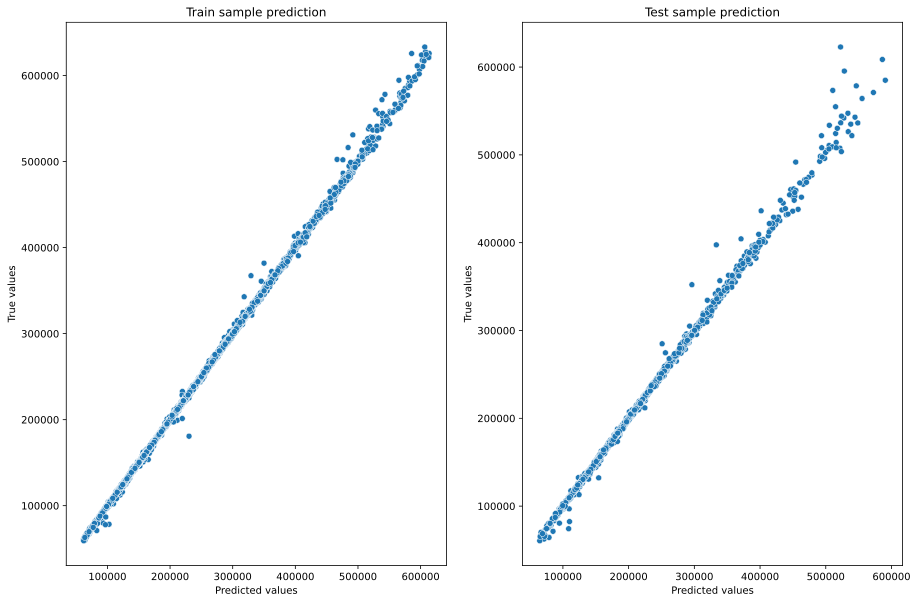

In [31]:
optim_model = RandomForestRegressor(n_estimators=200, random_state=seed, max_features=15, max_depth=30)
optim_model.fit(X_train, Y_train)

Y_train_preds = optim_model.predict(X_train)
Y_valid_preds = optim_model.predict(X_valid)

evaluate_preds(Y_train, Y_train_preds, Y_valid, Y_valid_preds)

Кросс-валидация

In [32]:
cv_score = cross_val_score(optim_model, X_train, Y_train, cv=KFold(n_splits=num_folds, random_state=42, shuffle=True), scoring='r2')
cv_score.mean()

0.9953257195225319

Определение значимости признаков.

In [33]:
feature_importances = pd.DataFrame(zip(X_train.columns, optim_model.feature_importances_),
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
17,Price_one_meter,0.497434
1,Square,0.436229
0,Rooms,0.031886
10,Social_1,0.013026
2,LifeSquare,0.011022
11,Social_2,0.002940
12,Social_3,0.002933
6,HouseYear,0.000845
13,Healthcare_1,0.000756
5,HouseFloor,0.000719


Обучаем нашу модель на всех данных датасета из train.csv

In [34]:
final_model = RandomForestRegressor(n_estimators=200, random_state=5, max_features=15, max_depth=30)
final_model.fit(X, Y)

RandomForestRegressor(max_depth=30, max_features=15, n_estimators=200,
                      random_state=5)

Загружаем данные из тестового датасета. 

In [35]:
test_df = pd.read_csv('test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Применяем к данным тестового датасета обработки, аналогичные тренировочным. 

In [36]:
prep = Data_prepr()
prep.fit(train_df)
prep.transform_em(test_df)
prep.transform_nan(test_df)
prep.transform_cat(test_df)

test_df[['Id', 'DistrictId']] = test_df[['Id', 'DistrictId']].astype('str')

test_df['Price_one_meter'] = test_df['DistrictId'].map(dict_price_one_meter)
test_df['Price_one_meter'].fillna(train_df['Price_one_meter'].median(), inplace=True)

copy_test_df = test_df.select_dtypes(include=['int', 'float']).copy()

Прогнозируем цену.

In [37]:
predictions = final_model.predict(copy_test_df)

In [38]:
test_df['price'] = predictions
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price_one_meter,price
0,4567,44,1.0,36.847630,19.094182,6.0,5,9.0,1970,0.036122,...,1,24,4378,0,1036.0,1,1,1,4610.399155,169765.744893
1,5925,62,1.0,42.493907,42.568133,6.0,7,17.0,2017,0.072158,...,1,2,629,1,900.0,0,0,0,2613.223638,111404.142082
2,960,27,2.0,59.463678,32.781260,6.0,19,19.0,1977,0.211401,...,1,9,1892,0,900.0,0,1,1,2760.361255,165254.054369
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,1,2,475,0,900.0,0,0,1,2275.654821,113652.115804
4,746,74,1.0,53.837056,32.781260,6.0,8,17.0,1977,0.309479,...,1,35,7715,4,990.0,0,6,1,3319.318045,180162.654664


In [39]:
test_df[['Id', 'price']].to_csv('Grishilova_predictions.csv', index=False)
